## Clarifying the cause of tensor exceptions

In [23]:
import tsensor
import graphviz
import torch
import sys

W = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([9, 10]).reshape(2, 1)
x = torch.tensor([4, 5]).reshape(2, 1)
h = torch.tensor([1,2])

In [57]:
try: # try is used just to catch the exception and extract the messages
    with tsensor.clarify():
        W @ torch.dot(b,b)+ torch.eye(2,2)@x + z
except BaseException as e:
    msgs = e.args[0].split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

PyTorch says: 1D tensors expected, got 2D, 2D tensors at /tmp/pip-req-build-as628lz5/aten/src/TH/generic/THTensorEvenMoreMath.cpp:83

tsensor adds: Cause: torch.dot(b,b) tensor arg b w/shape [2, 1], arg b w/shape [2, 1]


In [55]:
try:
    with tsensor.clarify():
        W.dot(h) + x
except BaseException as e:
    msgs = e.args[0].split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

PyTorch says: 1D tensors expected, got 2D, 1D tensors at /tmp/pip-req-build-as628lz5/aten/src/TH/generic/THTensorEvenMoreMath.cpp:83

tsensor adds: Cause: W.dot(h) tensor arg h w/shape [2]


## Explaining matrix algebra statements visually

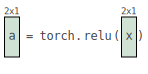

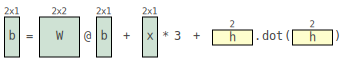

In [30]:
with tsensor.explain():
    a = torch.relu(x)
    b = W @ b + x * 3 + h.dot(h)

### Saving explanations to files

In [6]:
with tsensor.explain(savefig="/tmp/foo"): # save foo-1.svg and foo-2.svg in /tmp
    a = torch.relu(x)
    b = W @ b + x * 3 + h.dot(h)

In [14]:
!ls -l /tmp/foo-?.svg

-rw-r--r--@ 1 parrt  wheel   5004 Sep  9 17:53 /tmp/foo-1.svg
-rw-r--r--@ 1 parrt  wheel  11068 Sep  9 17:53 /tmp/foo-2.svg


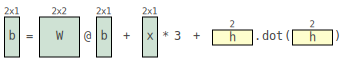

In [12]:
from IPython.display import SVG
display(SVG("/tmp/foo-2.svg"))

### Lower-level API to show abstract parse trees and evaluate them

In [53]:
frame = sys._getframe() # where are we executing right now

#### Get ast and computation result

In [3]:
root, result = tsensor.eval("W @ b + x * 3 + h.dot(h)", frame)
result

tensor([[237],
        [506]])

#### Show the ast

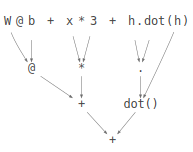

In [4]:
tsensor.astviz("W @ b + x * 3 + h.dot(h)")

#### Show specific code w/o need of a `with` statement:

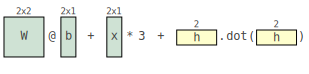

In [5]:
tsensor.pyviz("W @ b + x * 3 + h.dot(h)", frame)